In [1]:
import os
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

In [14]:
def apply_sunset_effect(image):
    if image is None or image.size == 0:
        return None
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    a = cv2.add(a, 15)
    b = cv2.add(b, 30)
    lab_sunset = cv2.merge([l, a, b])
    sunset_image = cv2.cvtColor(lab_sunset, cv2.COLOR_LAB2BGR)
    alpha = 1.3
    beta = 30
    sunset_image = cv2.convertScaleAbs(sunset_image, alpha=alpha, beta=beta)
    warm_overlay = np.full_like(sunset_image, (40, 100, 200), dtype=np.uint8)
    sunset_image = cv2.addWeighted(sunset_image, 0.8, warm_overlay, 0.2, 0)
    blur = cv2.GaussianBlur(sunset_image, (21, 21), 0)
    sunset_image = cv2.addWeighted(sunset_image, 0.85, blur, 0.15, 0)
    h, w, _ = sunset_image.shape
    gradient = np.linspace(1, 0.5, h).reshape(h, 1, 1)
    gradient = np.tile(gradient, (1, w, 3))
    shadowed_image = (sunset_image * gradient).astype(np.uint8)
    return shadowed_image

In [15]:
# --- DATA PREPARATION ---

class SunsetDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load {image_path}. Skipping.")
            return self.__getitem__((idx + 1) % len(self))
        
        image = apply_sunset_effect(image)
        if image is None:
            print(f"Invalid image after effect. Skipping {image_path}.")
            return self.__getitem__((idx + 1) % len(self))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, image

In [3]:
# --- PIX2PIX MODEL ---

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# --- TRAINING LOOP ---

def train_pix2pix(dataloader, generator, optimizer, criterion, device, num_epochs):
    generator.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sunset, daylight in tqdm(dataloader):
            sunset, daylight = sunset.to(device), daylight.to(device)
            optimizer.zero_grad()
            output = generator(sunset)
            loss = criterion(output, daylight)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader):.4f}')
    
    # Save the trained model
    torch.save(generator.state_dict(), 'pix2pix_sunset_to_daylight.pth')
    print('Training complete. Model saved.')

In [24]:
# --- MAIN ---

image_dir = '/kaggle/input/landscape-pictures/'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = SunsetDataset(image_dir, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGenerator().to(device)
optimizer = optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
criterion = nn.L1Loss()

train_pix2pix(dataloader, generator, optimizer, criterion, device, num_epochs=20)

print('Training complete. Model saved.')

100%|██████████| 270/270 [04:47<00:00,  1.06s/it]


Epoch 1/20, Loss: 0.0769


100%|██████████| 270/270 [04:44<00:00,  1.05s/it]


Epoch 2/20, Loss: 0.0326


100%|██████████| 270/270 [04:47<00:00,  1.06s/it]


Epoch 3/20, Loss: 0.0279


100%|██████████| 270/270 [04:49<00:00,  1.07s/it]


Epoch 4/20, Loss: 0.0254


100%|██████████| 270/270 [04:50<00:00,  1.08s/it]


Epoch 5/20, Loss: 0.0240


100%|██████████| 270/270 [04:49<00:00,  1.07s/it]


Epoch 6/20, Loss: 0.0236


100%|██████████| 270/270 [04:49<00:00,  1.07s/it]


Epoch 7/20, Loss: 0.0229


100%|██████████| 270/270 [04:49<00:00,  1.07s/it]


Epoch 8/20, Loss: 0.0226


100%|██████████| 270/270 [04:46<00:00,  1.06s/it]


Epoch 9/20, Loss: 0.0222


100%|██████████| 270/270 [04:45<00:00,  1.06s/it]


Epoch 10/20, Loss: 0.0220


100%|██████████| 270/270 [04:47<00:00,  1.06s/it]


Epoch 11/20, Loss: 0.0210


100%|██████████| 270/270 [04:48<00:00,  1.07s/it]


Epoch 12/20, Loss: 0.0206


100%|██████████| 270/270 [04:48<00:00,  1.07s/it]


Epoch 13/20, Loss: 0.0208


100%|██████████| 270/270 [04:46<00:00,  1.06s/it]


Epoch 14/20, Loss: 0.0196


100%|██████████| 270/270 [04:44<00:00,  1.05s/it]


Epoch 15/20, Loss: 0.0199


100%|██████████| 270/270 [04:46<00:00,  1.06s/it]


Epoch 16/20, Loss: 0.0197


100%|██████████| 270/270 [04:50<00:00,  1.07s/it]


Epoch 17/20, Loss: 0.0188


100%|██████████| 270/270 [04:44<00:00,  1.05s/it]


Epoch 18/20, Loss: 0.0186


100%|██████████| 270/270 [04:44<00:00,  1.05s/it]


Epoch 19/20, Loss: 0.0188


100%|██████████| 270/270 [04:45<00:00,  1.06s/it]

Epoch 20/20, Loss: 0.0180
Training complete. Model saved.
Training complete. Model saved.


<ipython-input-29-b71bfcadf1df>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('pix2pix_sunset_to_daylight.pth', map_location=device)

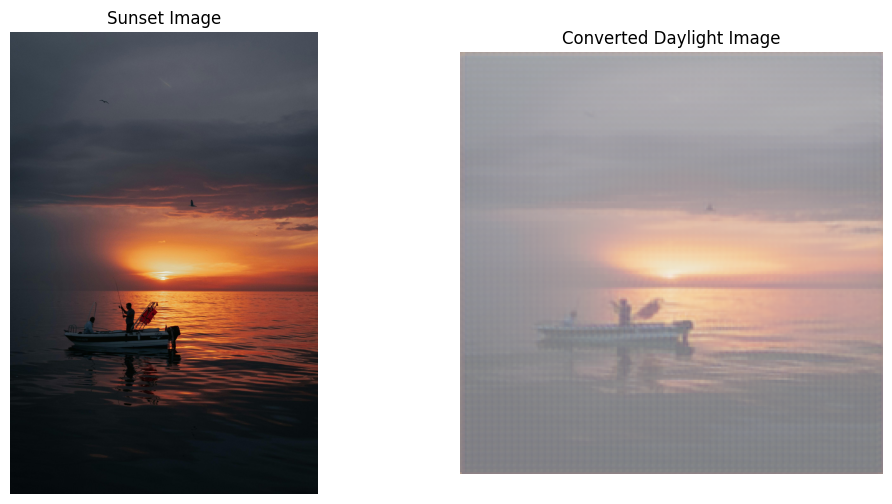

In [29]:
def display_test_results(model, sunset_image_path, device):
    model.eval()
    sunset = cv2.imread(sunset_image_path)
    sunset = cv2.cvtColor(sunset, cv2.COLOR_BGR2RGB)
    sunset_pil = Image.fromarray(sunset)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    sunset_tensor = transform(sunset_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(sunset_tensor).squeeze(0).cpu().permute(1, 2, 0).numpy()
        output = (output * 0.5 + 0.5) * 255
        output = np.clip(output, 0, 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(sunset)
    axes[0].set_title('Sunset Image')
    axes[0].axis('off')
    axes[1].imshow(output)
    axes[1].set_title('Converted Daylight Image')
    axes[1].axis('off')
    plt.show()
    
# Load the saved model weights
generator.load_state_dict(torch.load('pix2pix_sunset_to_daylight.pth', map_location=device))

# Display the test results
display_test_results(generator, '/kaggle/input/sunset-jpg/Image2.jpg', device)